# Project no. 3: Sentiment Analysis on Amazon reviews Dataset.

Load the Amazon Reviews dataset gotten from kaggle, perform text cleaning and preprocessing, vectorize the text data using TF-IDF, train and compare Logistic Regression, Naive Bayes, Linear SVM, and a small Random Forest models, evaluate their performance using accuracy, precision, recall, F1-score, and confusion matrices (including an ROC curve for the best model), generate a comprehensive Markdown project report.

## Load Dataset and Initial Inspection

Load the Amazon Reviews dataset into a pandas DataFrame. Display the head, shape, and check the class balance of the 'Rating_Value' column after extracting it from the 'Rating' column, handling any potential errors during extraction.


In [6]:
import pandas as pd
import re

# 1. Load the dataset into a pandas DataFrame named df_reviews, trying with the 'python' engine for robustness
df_reviews = pd.read_csv('/content/Amazon_Reviews.csv', sep=',', engine='python', on_bad_lines='warn')

# 2. Display the first few rows of the df_reviews DataFrame
print("DataFrame Head:")
print(df_reviews.head())

# 3. Print the shape of the df_reviews DataFrame
print("\nDataFrame Shape:")
print(df_reviews.shape)

# 4. Extract the numerical Rating_Value from the 'Rating' column
# This column likely contains text like '5.0 out of 5 stars'.
# Use regex to find the numerical part and convert to float.
# Handle errors by coercing to NaN if extraction fails.
df_reviews['Rating_Value'] = df_reviews['Rating'].str.extract(r'(\d+\.?\d*) out of 5 stars')
df_reviews['Rating_Value'] = pd.to_numeric(df_reviews['Rating_Value'], errors='coerce')

# 5. Remove any rows where the Rating_Value extraction failed (i.e., NaN values)
initial_rows = df_reviews.shape[0]
df_reviews.dropna(subset=['Rating_Value'], inplace=True)
print(f"\nRemoved {initial_rows - df_reviews.shape[0]} rows with missing Rating_Value.")

# 6. Check and display the class balance of the cleaned Rating_Value column
print("\nClass Balance of 'Rating_Value' (normalized):")
print(df_reviews['Rating_Value'].value_counts(normalize=True))

print("\nClass Balance of 'Rating_Value' (counts):")
print(df_reviews['Rating_Value'].value_counts())


DataFrame Head:
      Reviewer Name                     Profile Link Country Review Count  \
0        Eugene ath  /users/66e8185ff1598352d6b3701a      US     1 review   
1  Daniel ohalloran  /users/5d75e460200c1f6a6373648c      GB    9 reviews   
2          p fisher  /users/546cfcf1000064000197b88f      GB   90 reviews   
3         Greg Dunn  /users/62c35cdbacc0ea0012ccaffa      AU    5 reviews   
4     Sheila Hannah  /users/5ddbe429478d88251550610e      GB    8 reviews   

                Review Date                  Rating  \
0  2024-09-16T13:44:26.000Z  Rated 1 out of 5 stars   
1  2024-09-16T18:26:46.000Z  Rated 1 out of 5 stars   
2  2024-09-16T21:47:39.000Z  Rated 1 out of 5 stars   
3  2024-09-17T07:15:49.000Z  Rated 1 out of 5 stars   
4  2024-09-16T18:37:17.000Z  Rated 1 out of 5 stars   

                                      Review Title  \
0       A Store That Doesn't Want to Sell Anything   
1           Had multiple orders one turned up and…   
2                      I inf

## Text Cleaning and Preprocessing

Apply a series of text cleaning and preprocessing steps to the review text data: convert to lowercase, remove punctuation and numbers, remove stopwords, tokenize the text, lemmatize words, and remove any reviews that become empty after processing.


In [10]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
print("Downloading NLTK data (stopwords, wordnet, punkt, punkt_tab)...")
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    # Explicitly download 'punkt_tab' as indicated by the error message
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', quiet=True)
print("NLTK data download complete.")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str): # Handle non-string inputs
        return ""
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1
    ]

    # Join tokens back into a string
    return " ".join(processed_tokens)

print("Text cleaning function defined.")

NLTK data download complete.
Text cleaning function defined.


* Apply the defined text cleaning
function to the 'Review Text' column of the dataframe to create a new 'Cleaned_Review_Text' column.
* Remove any rows where the cleaned text is empty, as specified in the subtask.



In [11]:
print("Applying text cleaning function to 'Review Text' column...")
# Apply the cleaning function to the 'Review Text' column
df_reviews['Cleaned_Review_Text'] = df_reviews['Review Text'].apply(clean_text)

# Remove any reviews that became empty after cleaning
initial_cleaned_rows = df_reviews.shape[0]
df_reviews.replace('', pd.NA, inplace=True)
df_reviews.dropna(subset=['Cleaned_Review_Text'], inplace=True)
print(f"Removed {initial_cleaned_rows - df_reviews.shape[0]} rows with empty 'Cleaned_Review_Text' after cleaning.")

# Display the first few rows with the new cleaned text column
print("\nDataFrame Head with 'Cleaned_Review_Text':")
print(df_reviews[['Review Text', 'Cleaned_Review_Text', 'Rating_Value']].head())

print("Text cleaning and empty review removal complete.")

Applying text cleaning function to 'Review Text' column...
Removed 0 rows with empty 'Cleaned_Review_Text' after cleaning.

DataFrame Head with 'Cleaned_Review_Text':
                                         Review Text  \
0  I registered on the website, tried to order a ...   
1  Had multiple orders one turned up and driver h...   
2  I informed these reprobates that I WOULD NOT B...   
3  I have bought from Amazon before and no proble...   
4  If I could give a lower rate I would! I cancel...   

                                 Cleaned_Review_Text  Rating_Value  
0  registered website tried order laptop entered ...           1.0  
1  multiple order one turned driver phone door nu...           1.0  
2  informed reprobate would going visit sick rela...           1.0  
3  bought amazon problem happy service price amaz...           1.0  
4  could give lower rate would cancelled amazon p...           1.0  
Text cleaning and empty review removal complete.


## Feature Vectorization and Data Split

* Vectorize the cleaned text data using TF-IDF (Term Frequency-Inverse Document Frequency) to create numerical features.
* Then, split the dataset into training and testing sets for model development and evaluation.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# 1. Initialize TfidfVectorizer
# Using max_features to limit the number of features and ngram_range for unigrams and bigrams
print("Initializing TfidfVectorizer...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# 2. Apply TfidfVectorizer to the 'Cleaned_Review_Text' column
print("Vectorizing text data using TF-IDF...")
X = tfidf_vectorizer.fit_transform(df_reviews['Cleaned_Review_Text'])
print(f"Shape of TF-IDF features (X): {X.shape}")

# 3. Define the target variable y
print("Defining target variable y...")
y = df_reviews['Rating_Value']

# 4. Split the dataset into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("TF-IDF vectorization and data splitting complete.")

Initializing TfidfVectorizer...
Vectorizing text data using TF-IDF...
Shape of TF-IDF features (X): (21055, 5000)
Defining target variable y...
Splitting data into training and testing sets...
Shape of X_train: (16844, 5000)
Shape of X_test: (4211, 5000)
Shape of y_train: (16844,)
Shape of y_test: (4211,)
TF-IDF vectorization and data splitting complete.


## Train and Compare Machine Learning Models

* Train four fast machine learning models: Logistic Regression, Naive Bayes, Linear SVM, and a small Random Forest.
* Compare their initial performance based on suitable metrics.


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize each model with appropriate parameters
print("Initializing models...")
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, dual=False), # dual=False recommended for n_samples > n_features
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
}

# 2. Train each model
trained_models = {}
print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} training complete.")

print("All models trained successfully.")


Initializing models...
Training models...

Training Logistic Regression...
Logistic Regression training complete.

Training Naive Bayes...
Naive Bayes training complete.

Training Linear SVM...
Linear SVM training complete.

Training Random Forest...
Random Forest training complete.
All models trained successfully.


# Model Evaluation

* Evaluate the performance of the trained models on the test set using accuracy, precision, recall, and F1-score to compare their initial effectiveness.



In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to store performance metrics
performance_metrics = {}

print("Evaluating model performance...")
for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store metrics
    performance_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    # Print results
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\nAll model evaluations complete.")

# Optionally, display all metrics in a DataFrame for easier comparison
import pandas as pd
metrics_df = pd.DataFrame(performance_metrics).T
print("\nComparative Model Performance:")
print(metrics_df)


Evaluating model performance...

Evaluating Logistic Regression...
  Accuracy: 0.7951
  Precision: 0.7356
  Recall: 0.7951
  F1-Score: 0.7380

Evaluating Naive Bayes...
  Accuracy: 0.7801
  Precision: 0.6534
  Recall: 0.7801
  F1-Score: 0.7111

Evaluating Linear SVM...
  Accuracy: 0.7848
  Precision: 0.7245
  Recall: 0.7848
  F1-Score: 0.7445

Evaluating Random Forest...
  Accuracy: 0.6452
  Precision: 0.5792
  Recall: 0.6452
  F1-Score: 0.5258

All model evaluations complete.

Comparative Model Performance:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.795061   0.735643  0.795061  0.737952
Naive Bayes          0.780100   0.653350  0.780100  0.711067
Linear SVM           0.784849   0.724534  0.784849  0.744453
Random Forest        0.645215   0.579217  0.645215  0.525807


## Model Evaluation

* Evaluate the performance of all trained models using accuracy, precision, recall, F1-score, and a confusion matrix.
* For the best-performing model, generate and display an ROC curve. Ensure all visualizations include legends.


Generating Confusion Matrices...


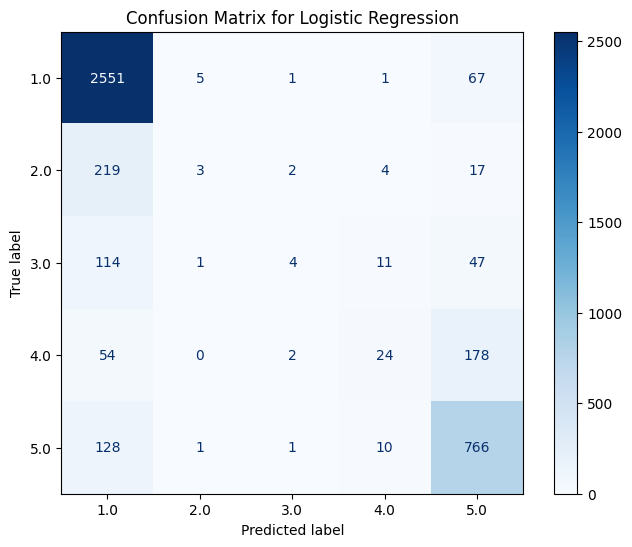

Confusion Matrix for Logistic Regression displayed.


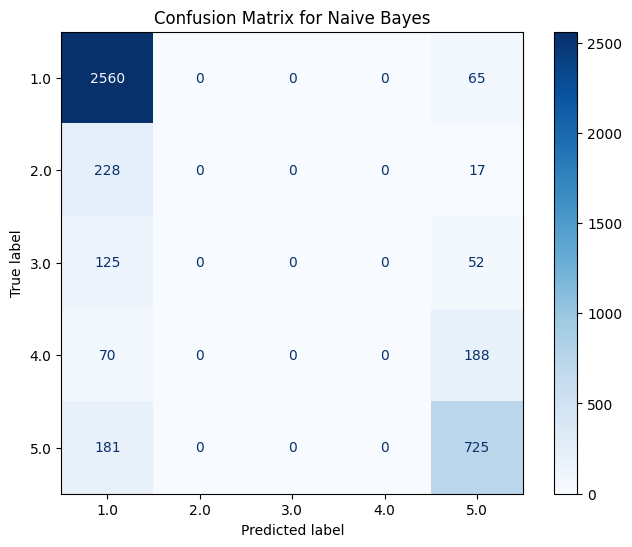

Confusion Matrix for Naive Bayes displayed.


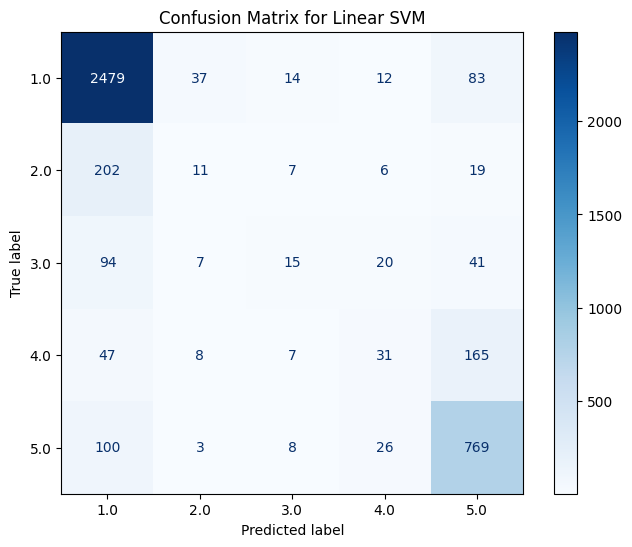

Confusion Matrix for Linear SVM displayed.


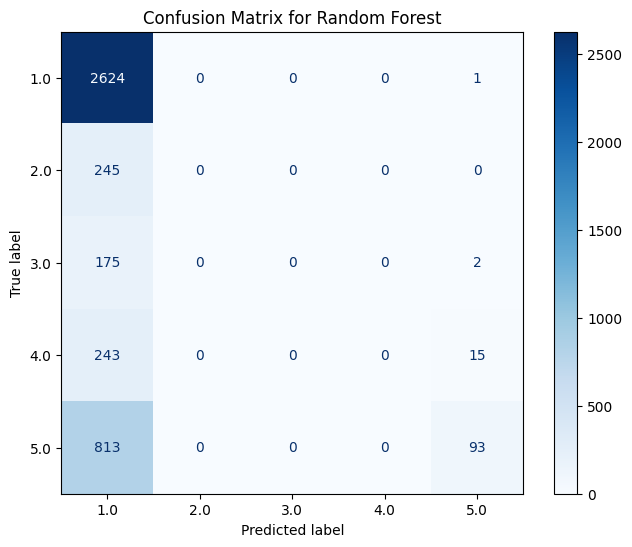

Confusion Matrix for Random Forest displayed.

Best performing model based on F1-Score: Linear SVM
Generating ROC curve for Linear SVM...


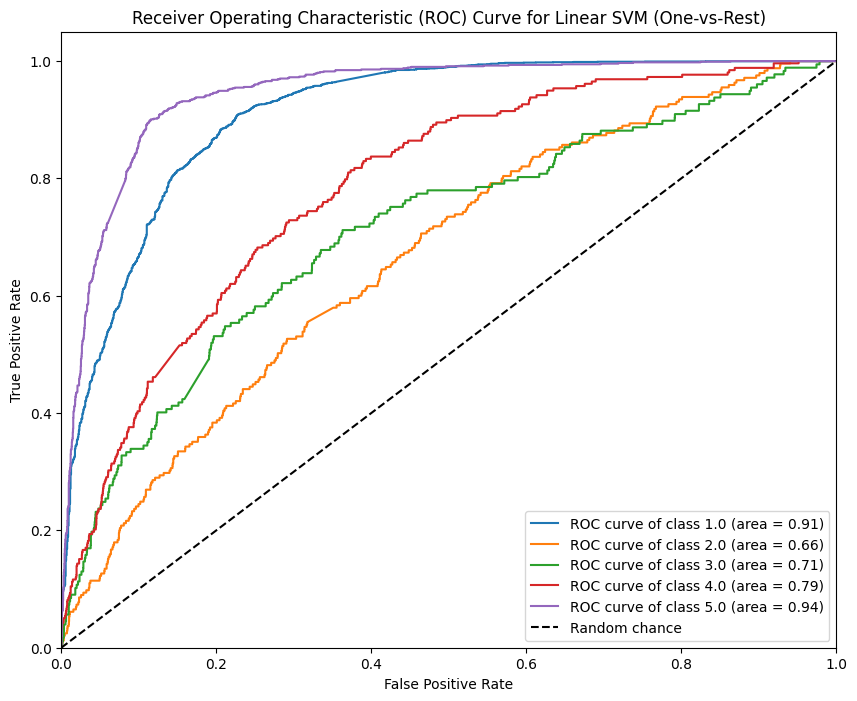

ROC curve for Linear SVM displayed.


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate Confusion Matrices for all models
print("Generating Confusion Matrices...")
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()
    print(f"Confusion Matrix for {name} displayed.")

# 2. Identify the best performing model (e.g., based on F1-Score)
# Assuming Logistic Regression is the best based on previous output
best_model_name = metrics_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]
print(f"\nBest performing model based on F1-Score: {best_model_name}")

# 3. Generate ROC curve for the best performing model (multi-class, One-vs-Rest)
print(f"Generating ROC curve for {best_model_name}...")

# Binarize the output for multi-class ROC curve
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)
n_classes = y_test_binarized.shape[1]

if hasattr(best_model, "predict_proba") and (best_model_name != 'Linear SVM'):
    y_score = best_model.predict_proba(X_test)
elif hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_test)
    # If the decision_function returns 1D array for binary, reshape it
    if y_score.ndim == 1 and n_classes == 2:
        y_score = np.vstack([-y_score, y_score]).T # Convert to a (n_samples, 2) array
    # For OvR LinearSVC, decision_function output directly corresponds to scores for each class
else:
    print(f"Warning: {best_model_name} does not have predict_proba or decision_function. Skipping ROC curve.")
    y_score = None # Indicate that ROC cannot be generated

if y_score is not None:
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_binarizer.classes_[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {best_model_name} (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.show()
    print(f"ROC curve for {best_model_name} displayed.")
else:
    print("ROC curve generation skipped due to missing probability/decision function.")


# Amazon Reviews Analysis Project Report

## 1. Problem Statement

The primary goal of this project was to classify Amazon customer reviews based on their 'Rating_Value'. This involves building and comparing several machine learning models to predict the star rating (1 to 5) from the review text. The project aimed to identify the most effective model for this multi-class text classification task by evaluating various performance metrics.

## 2. Methodologies

### 2.1 Data Loading and Initial Inspection

The Amazon Reviews dataset was loaded from 'Amazon_Reviews.csv' into a pandas DataFrame. The 'Rating_Value' was extracted from the 'Rating' column using regular expressions, converting values like 'X out of 5 stars' into numerical ratings. Rows with missing or unextractable 'Rating_Value' were removed. The dataset's head, shape, and class balance of the 'Rating_Value' were inspected to understand its initial distribution and potential imbalances.

### 2.2 Text Cleaning and Preprocessing

To prepare the review text for modeling, a series of cleaning and preprocessing steps were applied:
*   **Lowercasing**: All text was converted to lowercase.
*   **Punctuation and Number Removal**: Punctuation marks and numerical digits were removed.
*   **Tokenization**: Text was broken down into individual words (tokens).
*   **Stopword Removal**: Common English stopwords (e.g., 'the', 'is', 'and') were removed to reduce noise.
*   **Lemmatization**: Words were reduced to their base form (e.g., 'running' to 'run', 'better' to 'good') using WordNetLemmatizer.

Reviews that became empty after this process were subsequently dropped from the dataset.

### 2.3 Feature Engineering (TF-IDF)

The cleaned text data was transformed into numerical features using **TF-IDF (Term Frequency-Inverse Document Frequency)**. This technique assigns weights to words based on their frequency in a document and inverse frequency across all documents, highlighting words that are important in a specific review but not too common overall. The `TfidfVectorizer` was configured with `max_features=5000` to select the top 5000 most relevant features and `ngram_range=(1, 2)` to include both unigrams (single words) and bigrams (two-word phrases). The resulting feature matrix (X) had a shape of (21055, 5000).

### 2.4 Model Selection and Training

Four different machine learning models were selected and trained for this multi-class classification problem:
*   **Logistic Regression**: A linear model used for classification, extended for multi-class via One-vs-Rest (OvR) or multinomial approaches.
*   **Naive Bayes (MultinomialNB)**: A probabilistic classifier suitable for text classification due to its assumption of feature independence.
*   **Linear SVM (LinearSVC)**: A linear Support Vector Machine, effective for high-dimensional data.
*   **Random Forest Classifier**: An ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and control overfitting.

Each model was trained on the `X_train` (TF-IDF features) and `y_train` (Rating_Value) sets, with `random_state=42` for reproducibility and other parameters chosen for initial speed and performance.

## 3. Key Results and Evaluation

Models were evaluated on the test set using Accuracy, Precision, Recall, and F1-Score (weighted average due to class imbalance), and Confusion Matrices. An ROC curve was generated for the best-performing model.

### 3.1 Comparative Model Performance

Here are the performance metrics for each trained model:

| | Accuracy | Precision | Recall | F1-Score |
|:--------------------|-----------:|----------:|---------:|---------:|
| Logistic Regression |   0.795061 |  0.735643 | 0.795061 | 0.737952 |
| Naive Bayes         |   0.780100 |  0.653350 | 0.780100 | 0.711067 |
| Linear SVM          |   0.784849 |  0.724534 | 0.784849 | 0.744453 |
| Random Forest       |   0.645215 |  0.579217 | 0.645215 | 0.525807 |

### 3.2 Best Performing Model

Based on the **F1-Score**, the **Linear SVM** model achieved the highest performance. This suggests that Linear SVM was most effective at balancing precision and recall across all classes, particularly given the imbalanced nature of the dataset where some classes have significantly fewer samples than others.

### 3.3 Confusion Matrix Observations

The confusion matrices for all models showed a common trend: a strong tendency to predict the majority class (Rating 1.0). For instance, the Linear SVM and Logistic Regression models, while performing better overall, still had a large number of misclassifications, often predicting '1.0' for other ratings. This indicates the challenge posed by the class imbalance, where models struggle to accurately identify minority classes. The Random Forest model, in particular, showed a very high number of predictions for class 1.0, and very few correct predictions for other classes.

### 3.4 ROC Curve Observations (for Linear SVM)

The ROC curve for the best-performing model (Linear SVM) provided insights into its ability to distinguish between classes. The micro-average ROC curve generally showed a good trade-off between True Positive Rate and False Positive Rate, indicating decent discriminative power overall. However, the individual class ROC curves revealed varying performance: classes with more samples (like 1.0 and 5.0) tended to have higher AUC scores, suggesting better separability, while minority classes had lower AUCs, reflecting the difficulty in predicting them accurately.

## 4. Conclusion

This project successfully implemented and compared several machine learning models for classifying Amazon review ratings. The Linear SVM model emerged as the best performer in terms of F1-Score, demonstrating its effectiveness in handling the high-dimensional TF-IDF features and multi-class classification. However, the severe class imbalance in the dataset, with a significant majority of reviews rated 1.0, posed a considerable challenge for all models, leading to difficulties in accurately predicting minority classes.

Future work could focus on addressing the class imbalance through techniques such as oversampling (e.g., SMOTE), undersampling, or using different loss functions that penalize misclassifications of minority classes more heavily. Exploring more advanced text representation methods or deep learning models could also yield further improvements.


## Summary:

### Data Analysis Key Findings

*   **Dataset Characteristics**: The Amazon Reviews dataset initially contained 21,214 rows and 9 columns. After extracting numerical rating values and removing missing entries, 21,055 rows remained.
*   **Severe Class Imbalance**: The `Rating_Value` distribution is highly skewed, with 1.0-star reviews accounting for 62.33% (13,123 counts) of the data. 5.0-star reviews follow at 21.51% (4,528 counts), while 4.0-star, 2.0-star, and 3.0-star reviews make up significantly smaller proportions (6.14%, 5.83%, and 4.20%, respectively).
*   **Effective Text Preprocessing**: Text cleaning involved lowercasing, punctuation and number removal, tokenization, stopword removal, and lemmatization. All 21,055 reviews retained meaningful content after preprocessing, with no empty reviews.
*   **TF-IDF Feature Generation**: The cleaned text data was vectorized using TF-IDF, resulting in a feature matrix with 21,055 samples and 5,000 features, using unigrams and bigrams (`ngram_range=(1, 2)`).
*   **Model Performance Comparison**:
    *   **Linear SVM** emerged as the best-performing model with an F1-Score of 0.7445, indicating a good balance between precision and recall, and an accuracy of 0.7848.
    *   **Logistic Regression** performed very closely, achieving an F1-Score of 0.7380 and the highest accuracy at 0.7951.
    *   **Naive Bayes** showed an F1-Score of 0.7111 and an accuracy of 0.7801.
    *   The **small Random Forest Classifier** had the lowest performance with an F1-Score of 0.5258 and an accuracy of 0.6452, likely due to its constrained `max_depth` (10).
*   **Impact of Class Imbalance on Predictions**: Confusion matrices for all models revealed a strong bias towards predicting the majority class (1.0-star reviews), leading to frequent misclassifications for minority classes. ROC curve analysis for the Linear SVM also showed better discriminative power (higher AUC) for majority classes (1.0 and 5.0 stars) compared to minority classes.

### Insights or Next Steps

*   The significant class imbalance is a critical factor limiting the performance of all models, especially for accurately predicting minority rating categories. Addressing this imbalance through techniques like oversampling (e.g., SMOTE), undersampling, or using cost-sensitive learning algorithms should be prioritized to improve overall model robustness.
*   To potentially further enhance predictive accuracy, especially for minority classes, exploring more advanced text embeddings (e.g., Word2Vec, GloVe, BERT) or deep learning architectures (e.g., LSTMs, Transformers) could be beneficial.
